
## Replace Lorenz equations in Dynamic System with Neural Networks

* Ref: Data Driven Dynamic Systems by Kutz


In [31]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F



rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]


In [32]:

## Simulate the Lorenz System

dt    = 0.01
T     = 8
t     = np.arange(0, T+dt, dt)
beta  = 8/3
sigma = 10
rho   = 28

n_trajectories = 100            ## number of trajectories


## np.random.seed(123)


In [33]:

print( len(t)-1 )
print(  n_trajectories * ( len(t) - 1 )   )


800
80000



## Matrices to store trajectory values generated by Lorenz simulation

* The simulation produces 2 key matrices: input and output. The input has the $ x_k $ data, and the output has the $ x_{k+1} $ which means it is the state advanced by $ \Delta t = 0.01 $


In [34]:


nn_input  = np.zeros(       ( n_trajectories * ( len(t) - 1 ), 3 )       )

nn_output = np.zeros_like(         nn_input                 )


In [35]:

print( nn_input.shape  )

print( nn_output.shape )


(80000, 3)
(80000, 3)



## The Lorenz equations function


In [36]:

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    
    x, y, z = x_y_z
    
    return [ sigma * (y - x), x * (rho - z) - y, x * y - beta * z ]



## Generate 100 Hundred initial conditions


In [37]:

x0 = -15 + 30 * np.random.random((100, 3))

print( x0.shape )
print(    x0    )


(100, 3)
[[-14.50822557   6.63553098 -14.76787458]
 [-12.45533168  -8.23504769  11.25373602]
 [ -4.09271046   1.19879806   2.04309641]
 [ -8.23609919   2.16440304   4.82855385]
 [ -6.0526382   -2.44119423  -1.40733226]
 [ 12.97051985   2.62481242  13.44757115]
 [  1.68104261   0.01684263 -14.89403367]
 [ -0.57332868  12.82364996  -9.04902933]
 [-13.43726597  -2.7966332   -3.82810558]
 [ 10.71459174 -14.20166653  12.60447689]
 [  5.42708997  12.12677982   3.22587212]
 [  9.35859937  -4.93368379  -4.51301316]
 [ -3.30377309   7.64391245  -3.92126477]
 [ -7.73340581  13.1300507   12.24033251]
 [ -4.53608052   4.03914211  -6.78473365]
 [ -8.81654614  -4.90981413  -5.18700322]
 [ 11.46828304   9.66911444   6.28869686]
 [ 13.78035676  -2.32369941  -7.64900884]
 [-11.47804688  -5.96839925 -10.64208798]
 [-12.23441708   3.0879659   -4.07437651]
 [  1.93711028  -9.25992838   5.30717579]
 [ -8.53483658  -6.65929219   7.25281266]
 [  1.79213687  -4.95490761   1.28966348]
 [  5.81954109  12.363963


## Run integration for each of the 100 initial conditions (  for x0_j in x0   )


In [38]:

integrate_list = [  integrate.odeint( lorenz_deriv, x0_j, t )  for x0_j in x0  ]

x_t            =    np.asarray(   integrate_list    )


In [39]:

x_t.shape


(100, 801, 3)


## Plot and create input and output matrices to train the NN


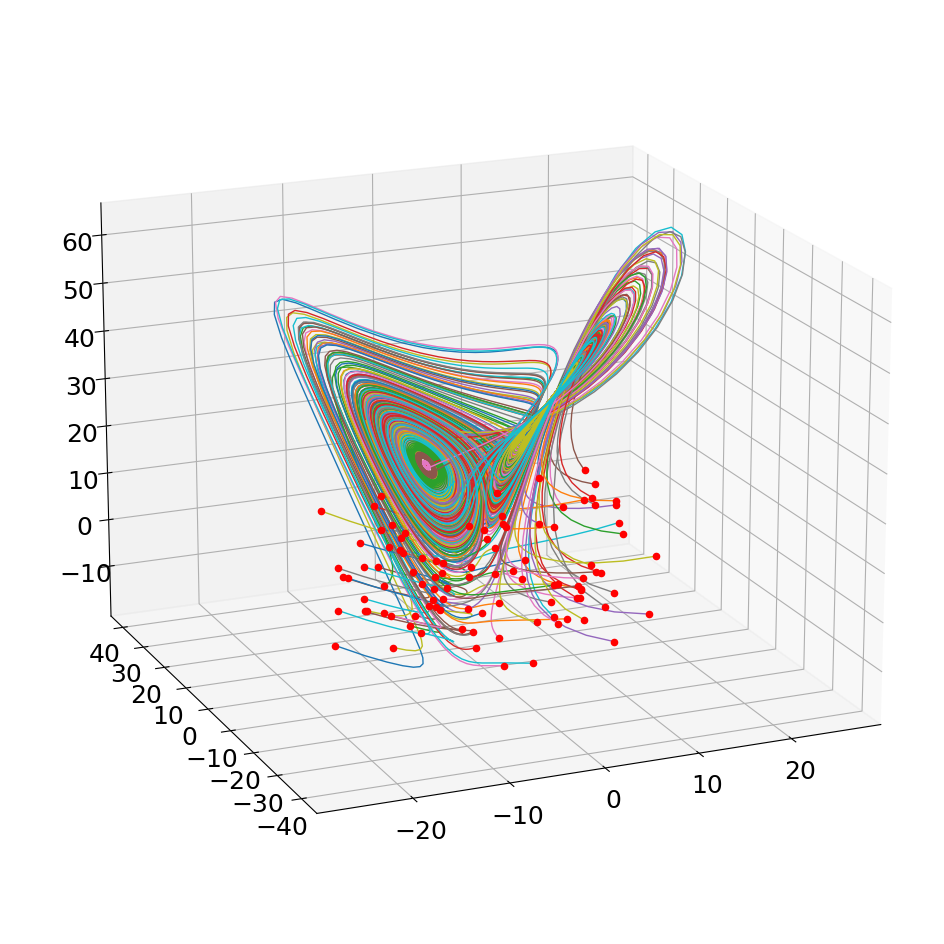

In [40]:

fig, ax = plt.subplots( 1, 1, subplot_kw={'projection': '3d'} )

for j in range(100):
    
    ##                                                 x_t is shifted
    nn_input[  j*( len(t)-1):(j+1)*(len(t)-1), :] = x_t[j, :-1, :]
    nn_output[ j*( len(t)-1):(j+1)*(len(t)-1), :] = x_t[j, 1:,  :]
    
    x, y, z = x_t[j,:,:].T
    
    ax.plot( x, y, z, linewidth=1 )
    
    ax.scatter( x0[j,0], x0[j,1], x0[j,2], color='r' )
    
        
ax.view_init(18, -113)
plt.show()



## The data will be used to train a NN to learn the non-linear mapping from $ x_k  $ to $  x_{k+1}  $ 


In [42]:

# Define activation functions
def logsig(x):
    return K.variable(np.divide(1,(1+np.exp(-K.eval(x)))))

def radbas(x):
    return K.variable(np.exp(-np.power(K.eval(x),2)))




## Neural Network architecture and training


In [43]:



model_3hidden = nn.Sequential(
      nn.Linear( 3, 10),
      nn.Sigmoid(),     ## Tanh(), sigmoid(), etc. 
      nn.Linear( 10, 10),
      nn.Tanh(),     ## Tanh(), sigmoid(), etc. nn.ReLU(),
      nn.Linear( 10, 10),
      nn.Tanh(),     ## Tanh(), sigmoid(), etc. 
      nn.Linear( 10, 3)  ##,
      ## nn.Softmax(dim=1)

)



In [44]:

loss_fn = loss_fn = F.mse_loss


In [45]:

model_fn = model_3hidden


In [46]:

learning_rate = 0.0003

n_epochs =  100

## momentum=0.9 for SGD

optimizer = optim.Adam(  model_fn.parameters() , lr=learning_rate  )


In [47]:

nn_input  = nn_input.astype(     np.float32  )
nn_output = nn_output .astype(   np.float32  )



In [48]:

train_torch_data = [( torch.tensor(nn_input[i]), torch.tensor(nn_output[i]) ) for i in range(nn_input.shape[0]) ]


In [51]:

batch_size = 32

train_DataLoader = torch.utils.data.DataLoader(train_torch_data, batch_size=batch_size, shuffle=True)


In [53]:


for epoch in range(n_epochs):
    for in_v3, out_v3 in train_DataLoader:
        ## print(in_v3)
        ## print(out_v3)
        preds = model_fn(in_v3)
        loss = loss_fn(  preds, out_v3  )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(epoch)
        print(loss)
    
    

0
tensor(6.5910, grad_fn=<MseLossBackward0>)
10
tensor(1.4061, grad_fn=<MseLossBackward0>)
20
tensor(0.0241, grad_fn=<MseLossBackward0>)
30
tensor(0.0298, grad_fn=<MseLossBackward0>)
40
tensor(0.0753, grad_fn=<MseLossBackward0>)
50
tensor(0.0118, grad_fn=<MseLossBackward0>)
60
tensor(0.0046, grad_fn=<MseLossBackward0>)
70
tensor(0.0064, grad_fn=<MseLossBackward0>)
80
tensor(0.0087, grad_fn=<MseLossBackward0>)
90
tensor(0.0015, grad_fn=<MseLossBackward0>)



## Now Predict with the NN


In [54]:
num_traj = 2


pred_delta_ts = len(t) + 8000

ynn = np.zeros(  (num_traj, pred_delta_ts, 3)  )
ynn.shape


(2, 8801, 3)


## initialize the 2 trajectories


In [55]:


ynn[:, 0, :] = -15 + 30 * np.random.random((num_traj, 3))



In [56]:

ynn


array([[[ 6.04079403,  6.22743356, 13.79817401],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[11.30114045, -0.95820998,  3.77719535],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]]])

In [57]:



ynn  = ynn.astype(     np.float32  )

for jj in range(  pred_delta_ts-1  ):
    ynn[:, jj+1, :] = model_fn(   torch.tensor( ynn[ :, jj, :] )   ).detach().numpy()





In [58]:
'''
ynn  = ynn.astype(     np.float32  )
ynn  = torch.tensor(  ynn  )

for jj in range(  len(t)-1  ):
    ynn[:, jj+1, :] = model_fn(   ynn[ :, jj, :]    )  
    
ynn_np = ynn.detach().numpy()

'''

'\nynn  = ynn.astype(     np.float32  )\nynn  = torch.tensor(  ynn  )\n\nfor jj in range(  len(t)-1  ):\n    ynn[:, jj+1, :] = model_fn(   ynn[ :, jj, :]    )  \n    \nynn_np = ynn.detach().numpy()\n\n'

In [59]:

ynn.shape


(2, 8801, 3)

In [60]:

ynn


array([[[  6.040794 ,   6.2274337,  13.798174 ],
        [  6.1078453,   7.0921164,  13.915473 ],
        [  6.251396 ,   7.9575768,  14.089958 ],
        ...,
        [  7.9787397,   8.3312   ,  26.92133  ],
        [  7.979582 ,   8.332168 ,  26.922302 ],
        [  7.9804254,   8.333052 ,  26.923393 ]],

       [[ 11.301141 ,  -0.95821  ,   3.7771955],
        [ 10.523429 ,   0.9107454,   3.9735875],
        [  9.953769 ,   2.668376 ,   4.1508136],
        ...,
        [-15.027792 , -11.363595 ,  39.953983 ],
        [-14.543668 ,  -9.455342 ,  40.370964 ],
        [-13.958033 ,  -7.578318 ,  40.47953  ]]], dtype=float32)


## Plot the predictions


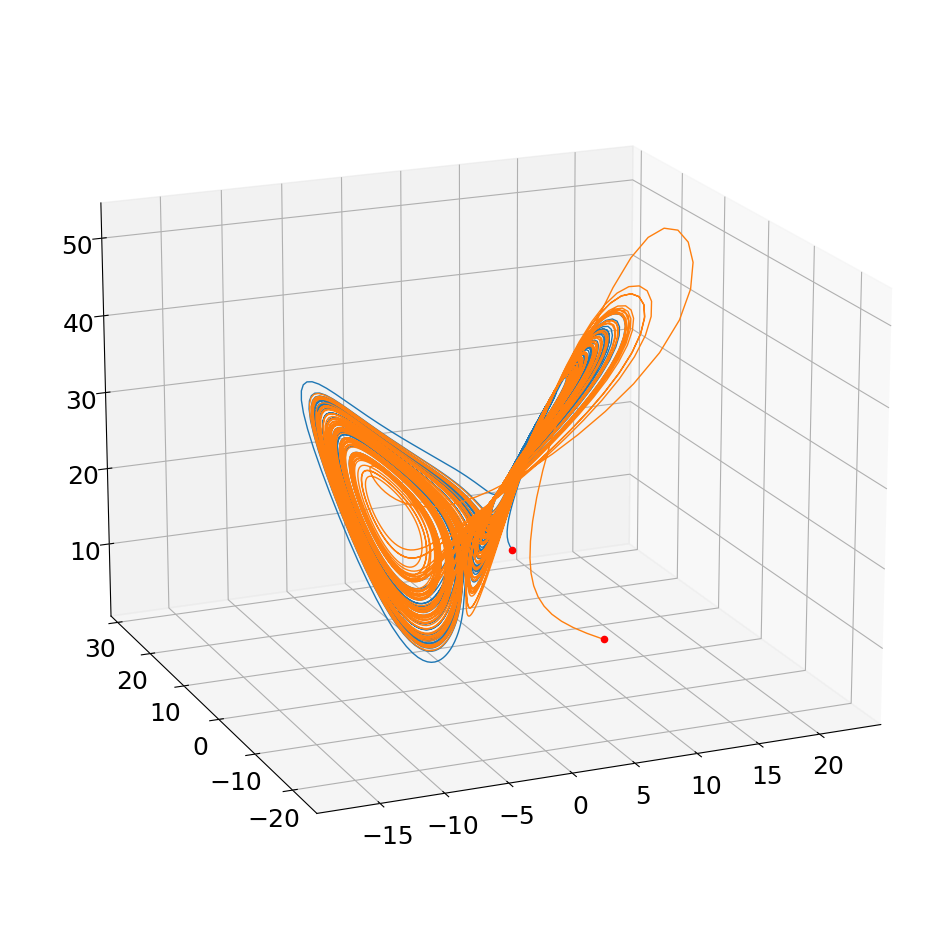

In [62]:



fig, ax = plt.subplots( 1, 1, subplot_kw={'projection': '3d'} )

for j in range(2):
    
   
    x, y, z = ynn[j,:,:].T
    
    ax.plot( x, y, z, linewidth=1 )
    
    ax.scatter( ynn[j,0,0], ynn[j,0,1], ynn[j,0, 2], color='r' )
    
        
ax.view_init(18, -113)
plt.show()
